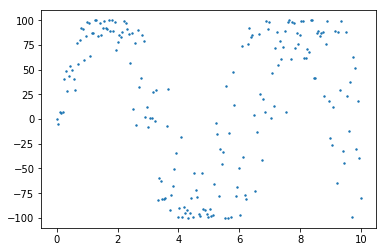

In [302]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

# Data
n = 200
x = np.linspace(0,10,n)
epis = np.random.uniform(-1,1,n)
y = np.sin(x + epis * (x/5)**0.5)

y = y*100

plt.scatter(x, y, s = 2)

In [303]:
x = x.reshape(n, 1)
x.shape

(200, 1)

## Non-Bayesian

In [304]:
# Network parameter
n_inputs = 1
n_hidden1 = 10
n_hidden2 = 10
n_outputs = 1

# tf Graph input
X_tf = tf.placeholder(tf.float32,
                  shape = (None, n_inputs),
                  name = 'X')
y_tf = tf.placeholder(tf.float32,
                  shape = (None),
                  name = 'y')

# Paraameters
learning_rate = 0.1
num_steps = 10000
batch_size = 100
display_step = 500

# Layer weights and bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_inputs, n_hidden1])),
    'h2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
    'out': tf.Variable(tf.random_normal([n_hidden2, n_outputs])), 
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden1])),
    'b2': tf.Variable(tf.random_normal([n_hidden2])),
    'out': tf.Variable(tf.random_normal([n_outputs])), 
}

# Model
def neural_net(x):
    # Hidden fully connected
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    #layer_1 = tf.nn.dropout(layer_1, keep_prob=0.8)
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    #layer_2 = tf.nn.dropout(layer_2, keep_prob=0.8)
    # Output
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    
    return out_layer

In [305]:
# Construct model
NN = neural_net(X_tf)

# Define loss function and optimizer
loss_op = tf.losses.mean_squared_error(labels = y_tf,
                                        predictions = tf.transpose(NN))
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss_op)

# Evaluate model

# Initialize the variables
init = tf.global_variables_initializer()

In [306]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    for step in range(1, num_steps+1):
        #batch_x = np.random.choice(x[:,0], batch_size).reshape(batch_size, 1)
        #batch_y = np.random.choice(y, batch_size)
        batch_x = x
        batch_y = y
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
        if step % display_step == 0 or step == 1:
            # Calcualte batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
            print("step " + str(step) + ", Minibatch Loss = " + str(loss))
    
    print("optimization finished")
    
    pred = sess.run(NN, feed_dict={X_tf: x})


step 1, Minibatch Loss = 9487.872
step 500, Minibatch Loss = 4721.841
step 1000, Minibatch Loss = 4393.1953
step 1500, Minibatch Loss = 4045.3513
step 2000, Minibatch Loss = 3646.228
step 2500, Minibatch Loss = 3170.3374
step 3000, Minibatch Loss = 2649.7046
step 3500, Minibatch Loss = 2194.7068
step 4000, Minibatch Loss = 1871.6663
step 4500, Minibatch Loss = 1651.121
step 5000, Minibatch Loss = 1505.6687
step 5500, Minibatch Loss = 1419.8656
step 6000, Minibatch Loss = 1375.1616
step 6500, Minibatch Loss = 1359.3053
step 7000, Minibatch Loss = 1352.5981
step 7500, Minibatch Loss = 1349.1997
step 8000, Minibatch Loss = 1345.7819
step 8500, Minibatch Loss = 1343.0657
step 9000, Minibatch Loss = 1335.0183
step 9500, Minibatch Loss = 1324.0095
step 10000, Minibatch Loss = 1321.8644
optimization finished


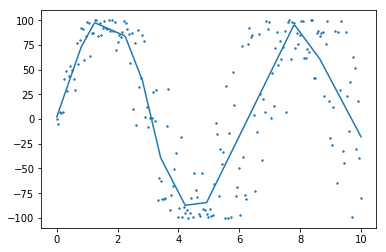

In [307]:
plt.scatter(x, y, s = 2)
plt.plot(x, pred)


## Bayesian

In [308]:
neural_net = tf.keras.Sequential([
    tfp.layers.DenseFlipout(30, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(30, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(1),
])

# Construct model
NN = neural_net(X_tf)

# Define loss function and optimizer
neg_log_likelihood  = tf.losses.mean_squared_error(labels = y_tf,
                                        predictions = tf.transpose(NN))

kl = sum(neural_net.losses)/n
loss_op = neg_log_likelihood + kl

optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss_op)

# Initialize the variables
init = tf.global_variables_initializer()

In [309]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    for step in range(1, num_steps+1):
        batch_x = x
        batch_y = y
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
        if step % display_step == 0 or step == 1:
            # Calcualte batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
            print("step " + str(step) + ", Minibatch Loss = " + str(loss))
    
    print("optimization finished")
    
    pred_mean = sess.run(NN, feed_dict={X_tf: x})
    
    # Draw sample for the weights and bias from the posterior
    n_sample = 100
    w0_draw = neural_net.layers[0].kernel_posterior.sample(n_sample).eval()
    w1_draw = neural_net.layers[1].kernel_posterior.sample(n_sample).eval()
    w2_draw = neural_net.layers[2].kernel_posterior.sample(n_sample).eval()
    b0_draw = neural_net.layers[0].bias_posterior.sample(n_sample).eval()
    b1_draw = neural_net.layers[1].bias_posterior.sample(n_sample).eval()
    b2_draw = neural_net.layers[2].bias_posterior.sample(n_sample).eval()



step 1, Minibatch Loss = 5173.6406
step 500, Minibatch Loss = 4201.287
step 1000, Minibatch Loss = 2580.3018
step 1500, Minibatch Loss = 2282.6536
step 2000, Minibatch Loss = 2127.6274
step 2500, Minibatch Loss = 1970.364
step 3000, Minibatch Loss = 1803.4387
step 3500, Minibatch Loss = 1687.9504
step 4000, Minibatch Loss = 1575.2502
step 4500, Minibatch Loss = 1486.4153
step 5000, Minibatch Loss = 1397.3049
step 5500, Minibatch Loss = 1369.125
step 6000, Minibatch Loss = 1413.2549
step 6500, Minibatch Loss = 1357.2765
step 7000, Minibatch Loss = 1417.606
step 7500, Minibatch Loss = 1347.7866
step 8000, Minibatch Loss = 1381.9379
step 8500, Minibatch Loss = 1344.3909
step 9000, Minibatch Loss = 1336.0568
step 9500, Minibatch Loss = 1342.3065
step 10000, Minibatch Loss = 1348.2866
optimization finished


In [310]:
def np_relu(x):
    return np.maximum(x, 0)

pred = []
for i in range(n_sample):
    pred.append(np_relu(np_relu(x.dot(w0_draw[i])+b0_draw[i]).dot(w1_draw[i])+b1_draw[i]).dot(w2_draw[i])+b2_draw[i])

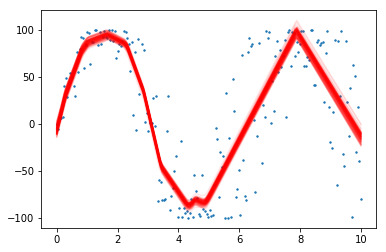

In [311]:
plt.scatter(x, y, s = 2)
for i in range(n_sample):
    plt.plot(x, pred[i], c = 'r', alpha = 0.1)
#plt.plot(x, pred_mean, c = 'g')



